In [1]:
!pip install umap-learn -q

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler

import umap

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Normalization values standard for CIFAR-10
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.4914, 0.4822, 0.4465],
                std=[0.2023, 0.1994, 0.2010]),
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

len(train_dataset)

100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


50000

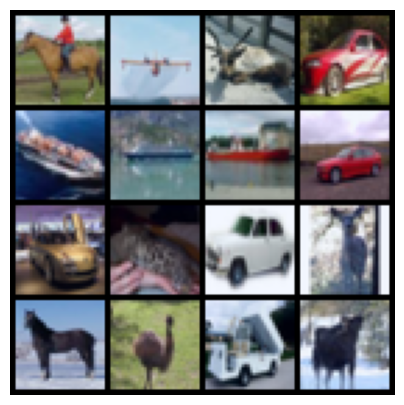

In [5]:
def show_batch(dataset, n=16):
    loader = DataLoader(dataset, batch_size=n, shuffle=True)
    imgs, labels = next(iter(loader))
    grid = torchvision.utils.make_grid(imgs, nrow=int(n**0.5), normalize=True)
    plt.figure(figsize=(5,5))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

show_batch(train_dataset)

In [6]:
resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

# Remove final fully connected layer -> keep up to avgpool
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor.to(device)
feature_extractor.eval()

for p in feature_extractor.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


In [7]:
batch_size = 128
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

all_feats = []
all_labels = []

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.to(device)
        feats = feature_extractor(imgs)       # [B, 512, 1, 1]
        feats = feats.view(feats.size(0), -1) # [B, 512]
        all_feats.append(feats.cpu().numpy())
        all_labels.append(labels.numpy())

X = np.concatenate(all_feats, axis=0)   # features
y_true = np.concatenate(all_labels, axis=0)  # true labels (for evaluation only)

X.shape, y_true.shape

((50000, 512), (50000,))

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(50000, 50)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


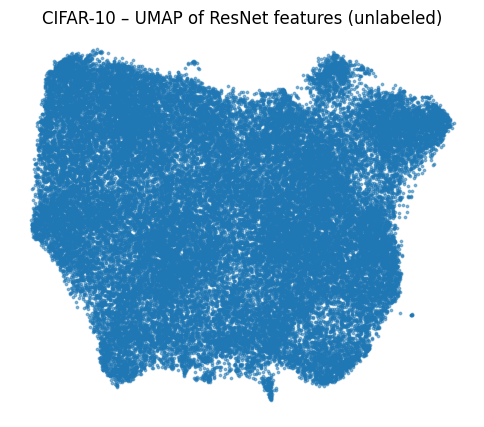

In [9]:
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)
X_umap = reducer.fit_transform(X_pca)

plt.figure(figsize=(6,5))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=3, alpha=0.5)
plt.title("CIFAR-10 – UMAP of ResNet features (unlabeled)")
plt.axis("off")
plt.show()

In [10]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

In [11]:
sil = silhouette_score(X_pca, clusters)
ari = adjusted_rand_score(y_true, clusters)
nmi = normalized_mutual_info_score(y_true, clusters)

print(f"Silhouette Score: {sil:.4f}")
print(f"Adjusted Rand Index (vs true labels): {ari:.4f}")
print(f"NMI (vs true labels): {nmi:.4f}")

Silhouette Score: 0.0499
Adjusted Rand Index (vs true labels): 0.1086
NMI (vs true labels): 0.1936


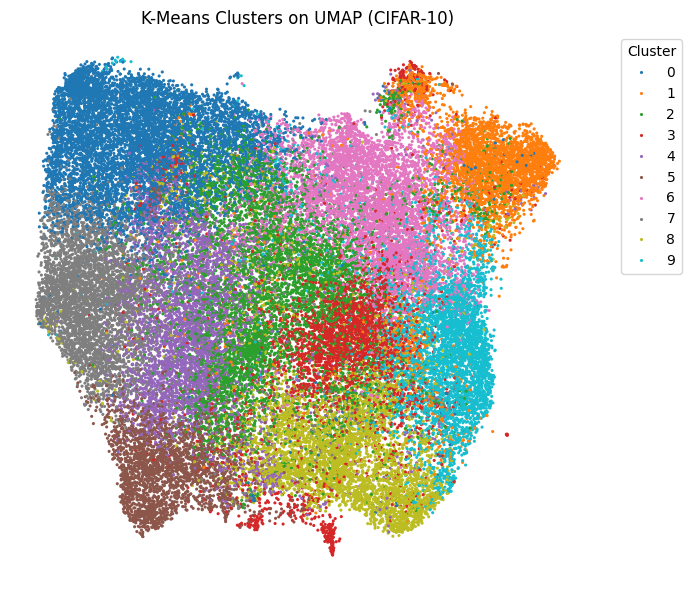

In [12]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_umap[:,0],
    y=X_umap[:,1],
    hue=clusters,
    palette="tab10",
    s=5,
    linewidth=0
)
plt.title("K-Means Clusters on UMAP (CIFAR-10)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05,1), loc="upper left")
plt.axis("off")
plt.tight_layout()
plt.show()

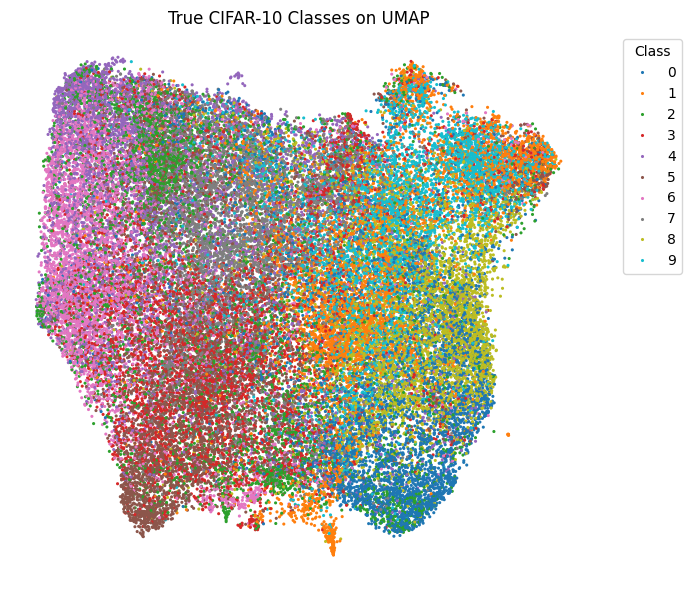

In [13]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_umap[:,0],
    y=X_umap[:,1],
    hue=y_true,
    palette="tab10",
    s=5,
    linewidth=0
)
plt.title("True CIFAR-10 Classes on UMAP")
plt.legend(title="Class", bbox_to_anchor=(1.05,1), loc="upper left")
plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

display_transform = T.Compose([
    T.ToTensor()
])

raw_train = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=False,
    transform=display_transform
)

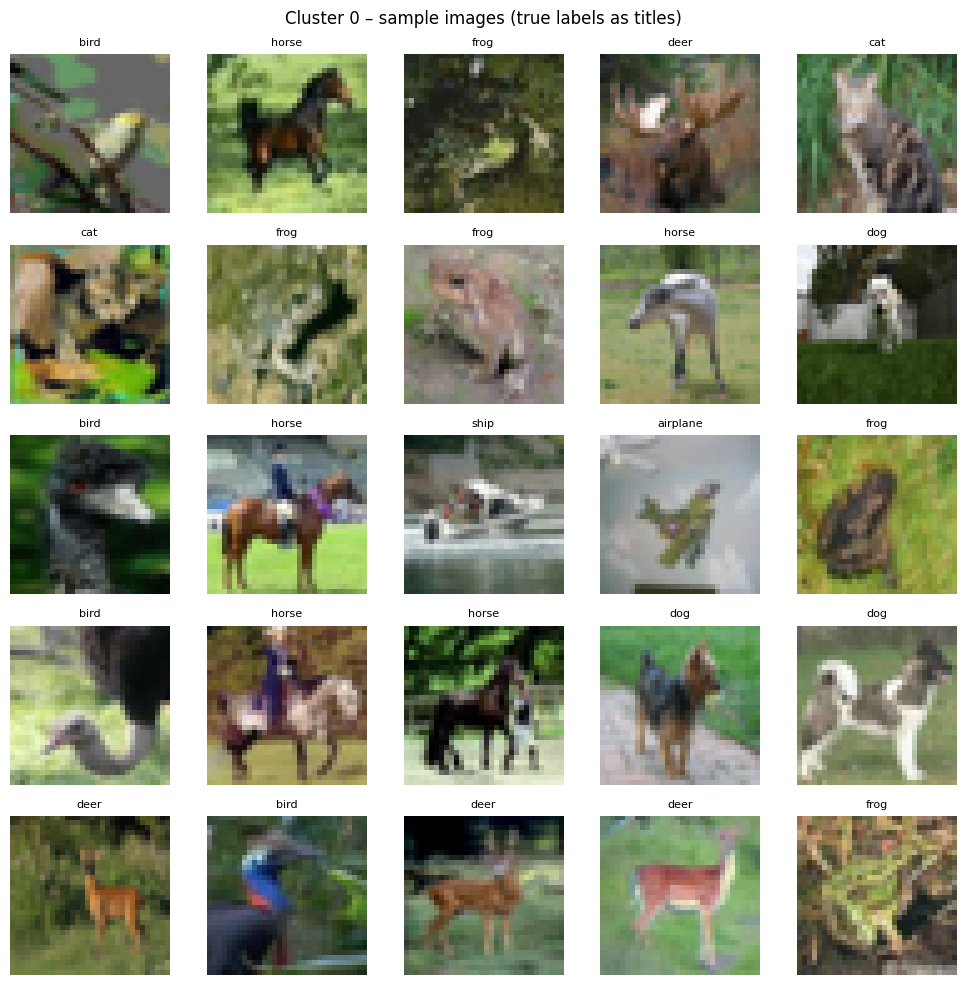

In [15]:
import math

def show_cluster_samples(cluster_id, n=25):
    idxs = np.where(clusters == cluster_id)[0]
    if len(idxs) == 0:
        print("No images in this cluster.")
        return

    n = min(n, len(idxs))
    chosen = np.random.choice(idxs, size=n, replace=False)

    imgs = []
    titles = []
    for i in chosen:
        img, label = raw_train[i]
        imgs.append(img)
        titles.append(class_names[label])

    cols = int(math.sqrt(n))
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    axes = axes.flatten()

    for ax, img, title in zip(axes, imgs, titles):
        ax.imshow(np.transpose(img.numpy(), (1,2,0)))
        ax.set_title(title, fontsize=8)
        ax.axis("off")

    # turn off any remaining axes
    for ax in axes[len(imgs):]:
        ax.axis("off")

    fig.suptitle(f"Cluster {cluster_id} – sample images (true labels as titles)", fontsize=12)
    plt.tight_layout()
    plt.show()

show_cluster_samples(0)

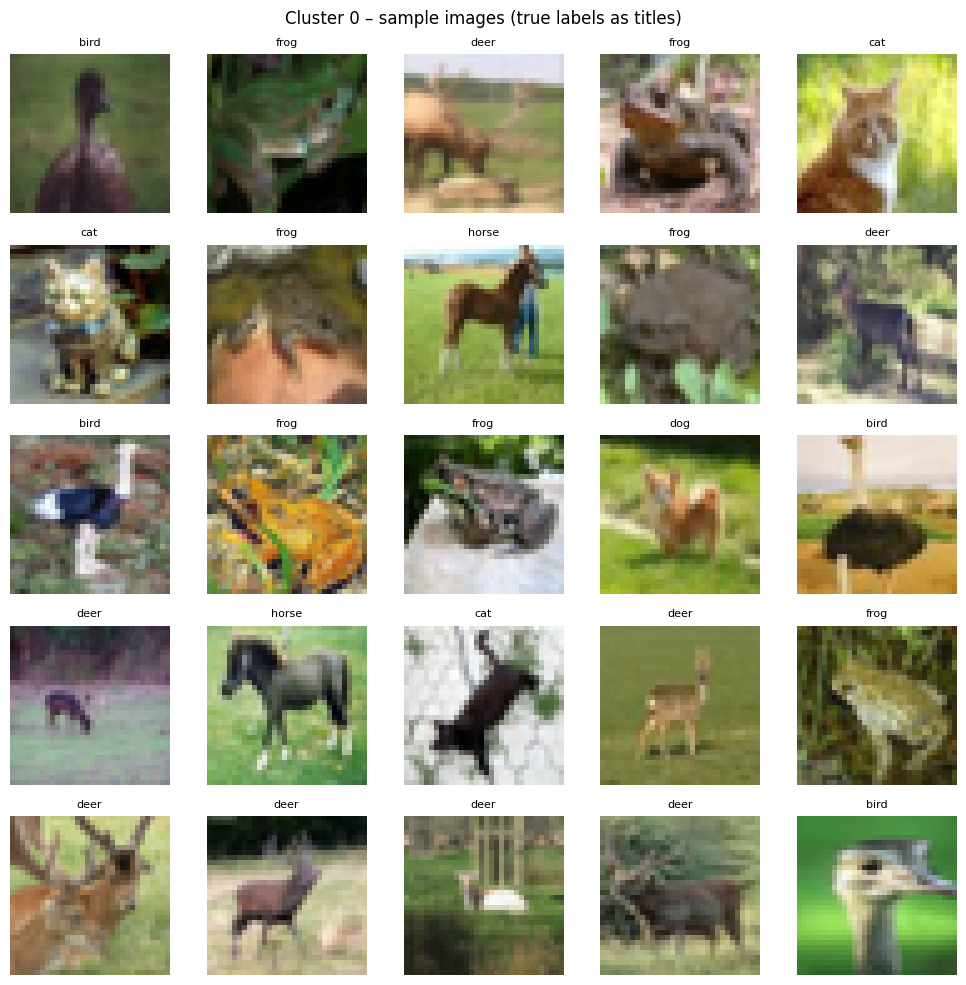

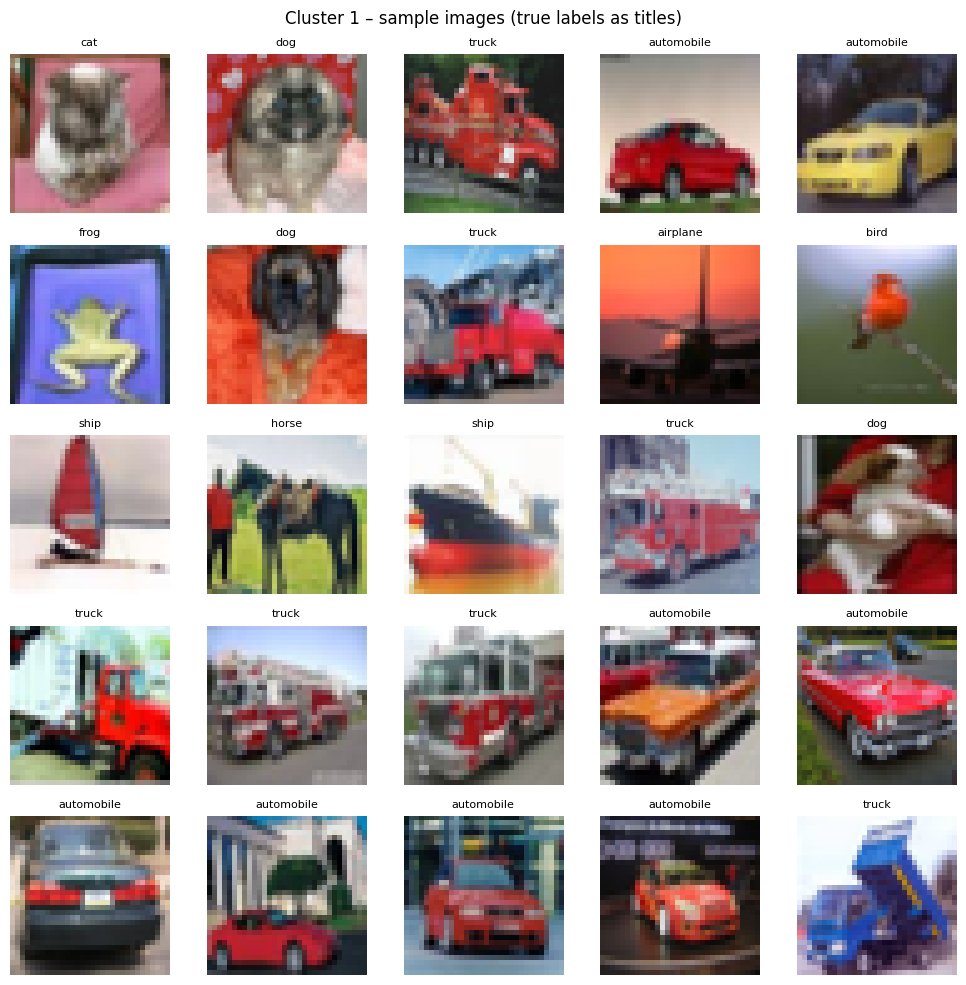

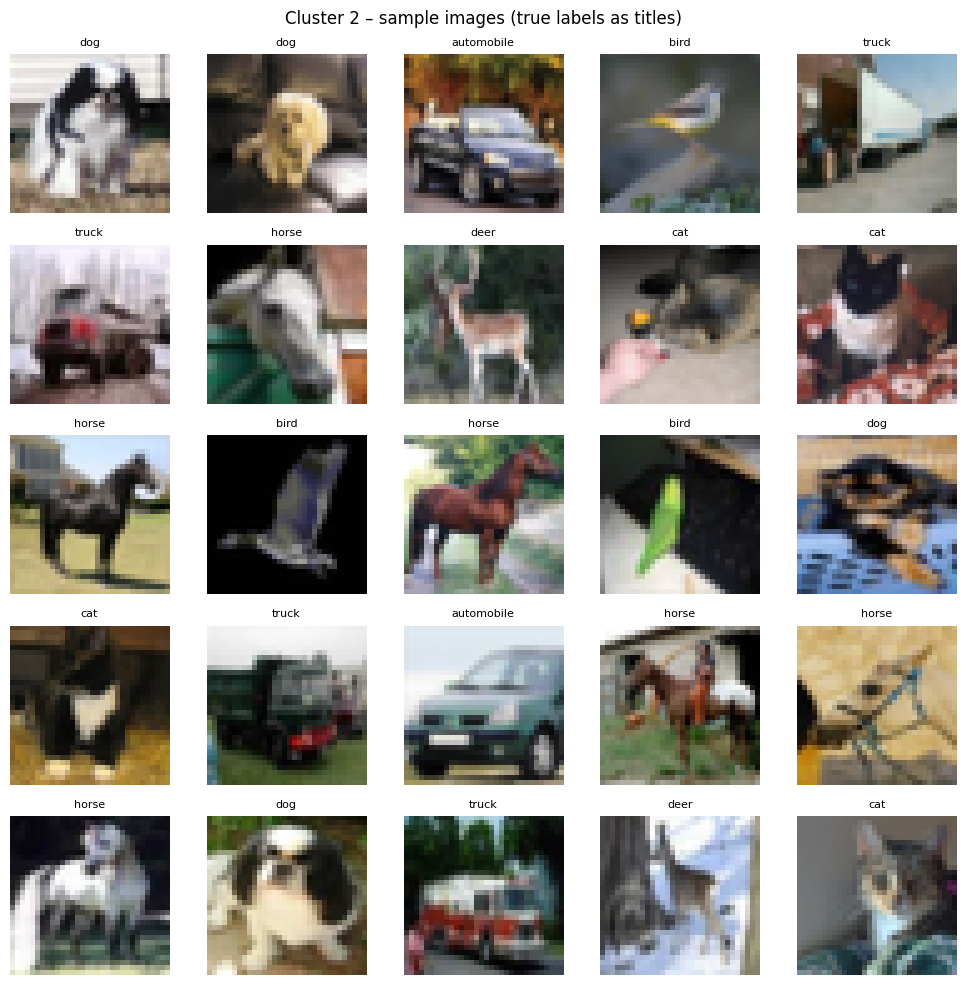

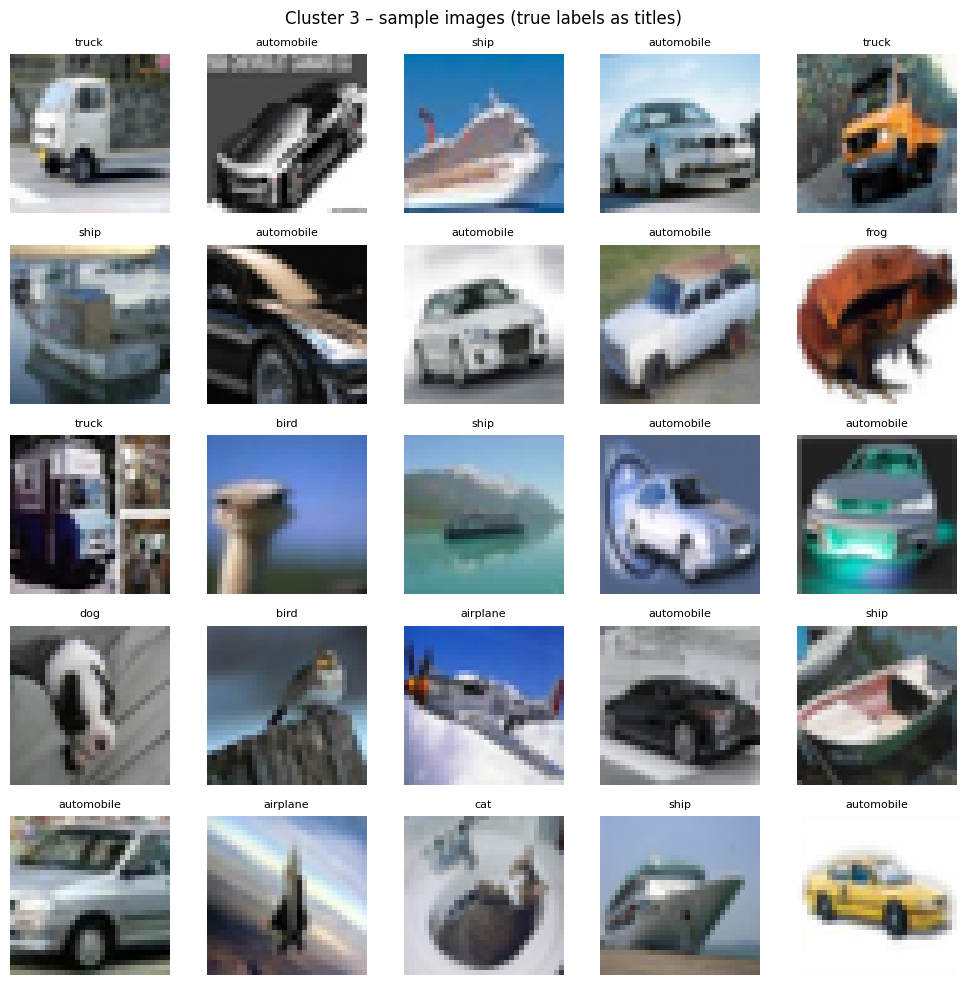

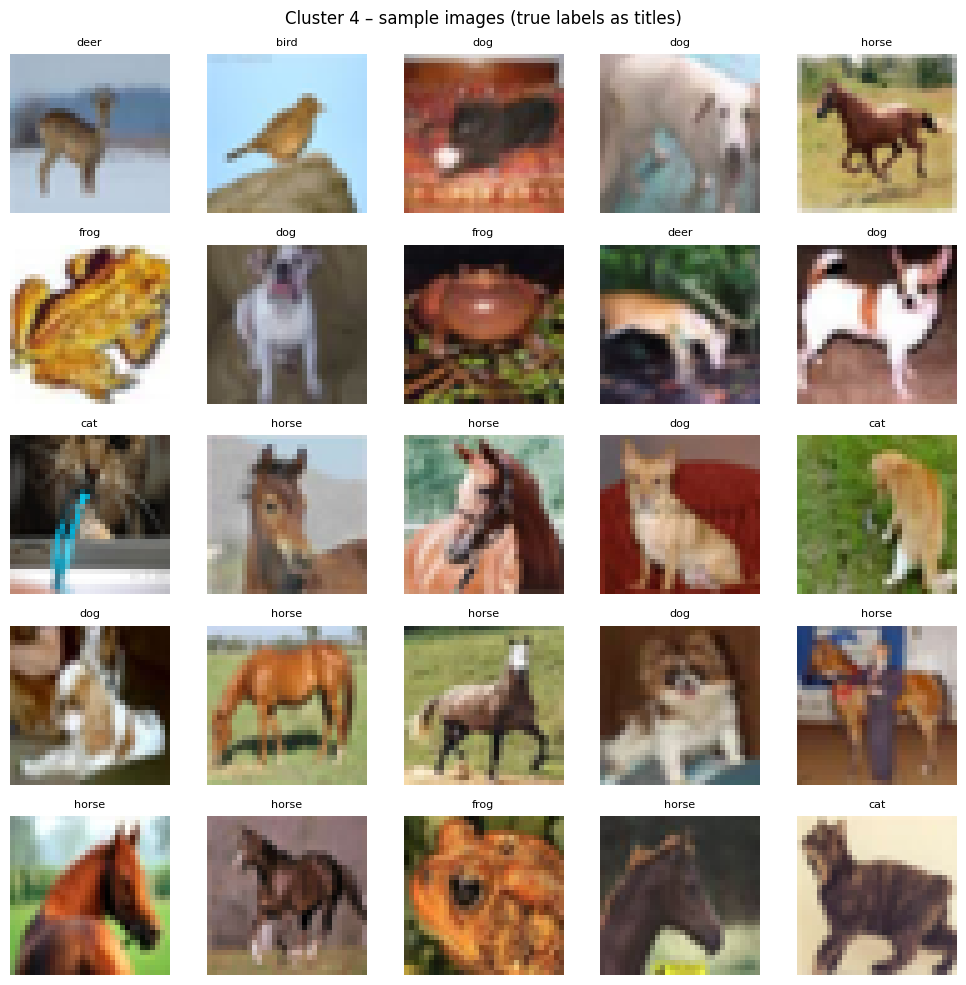

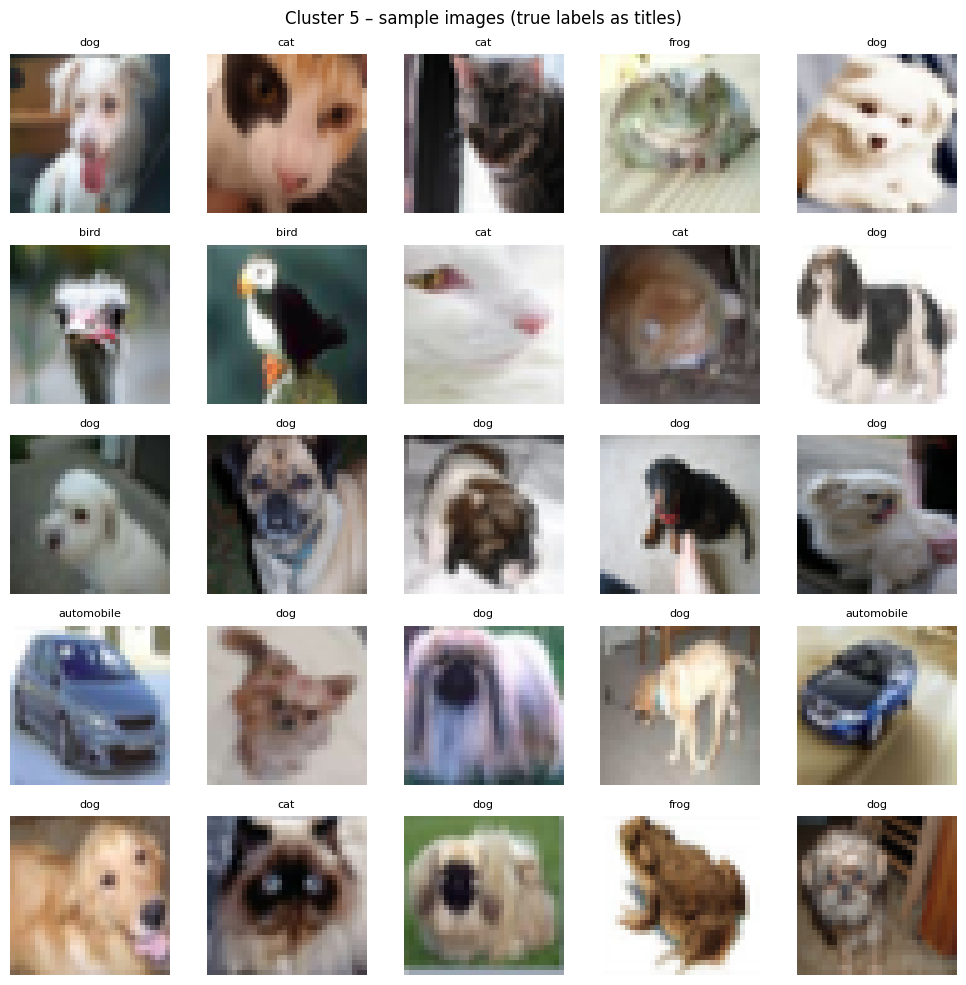

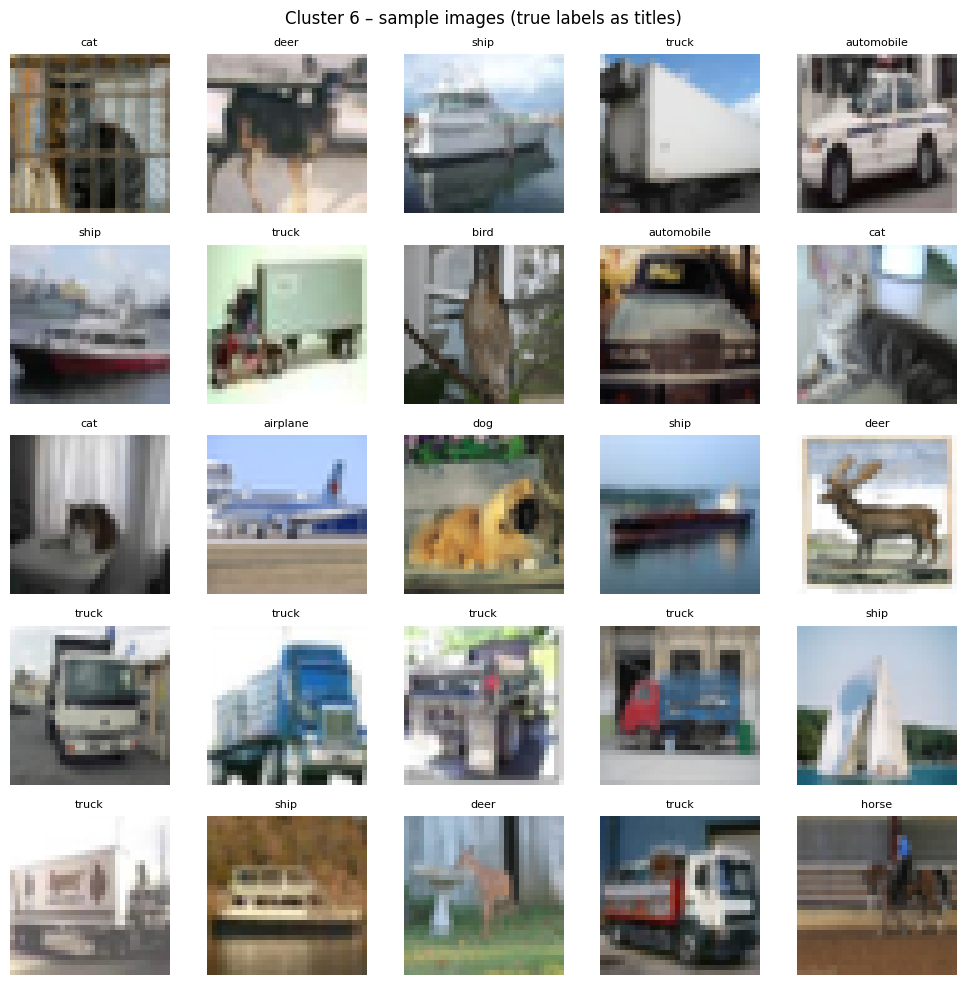

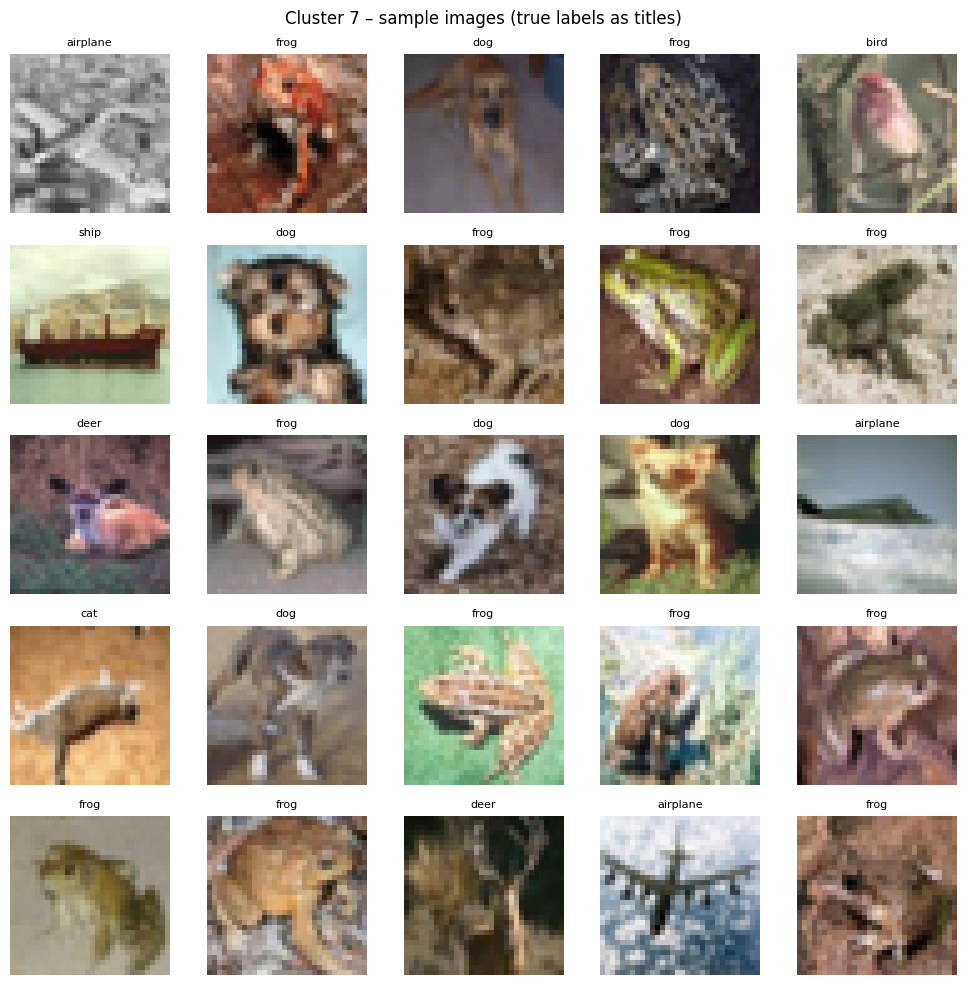

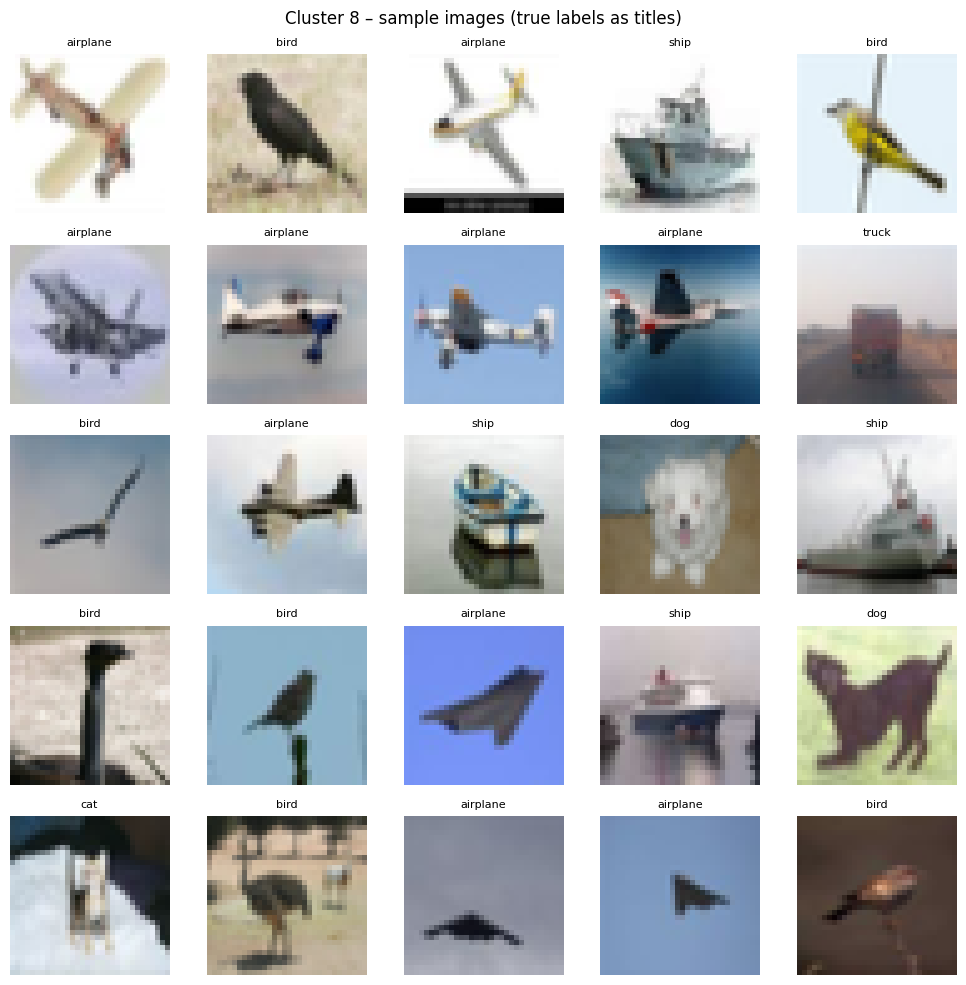

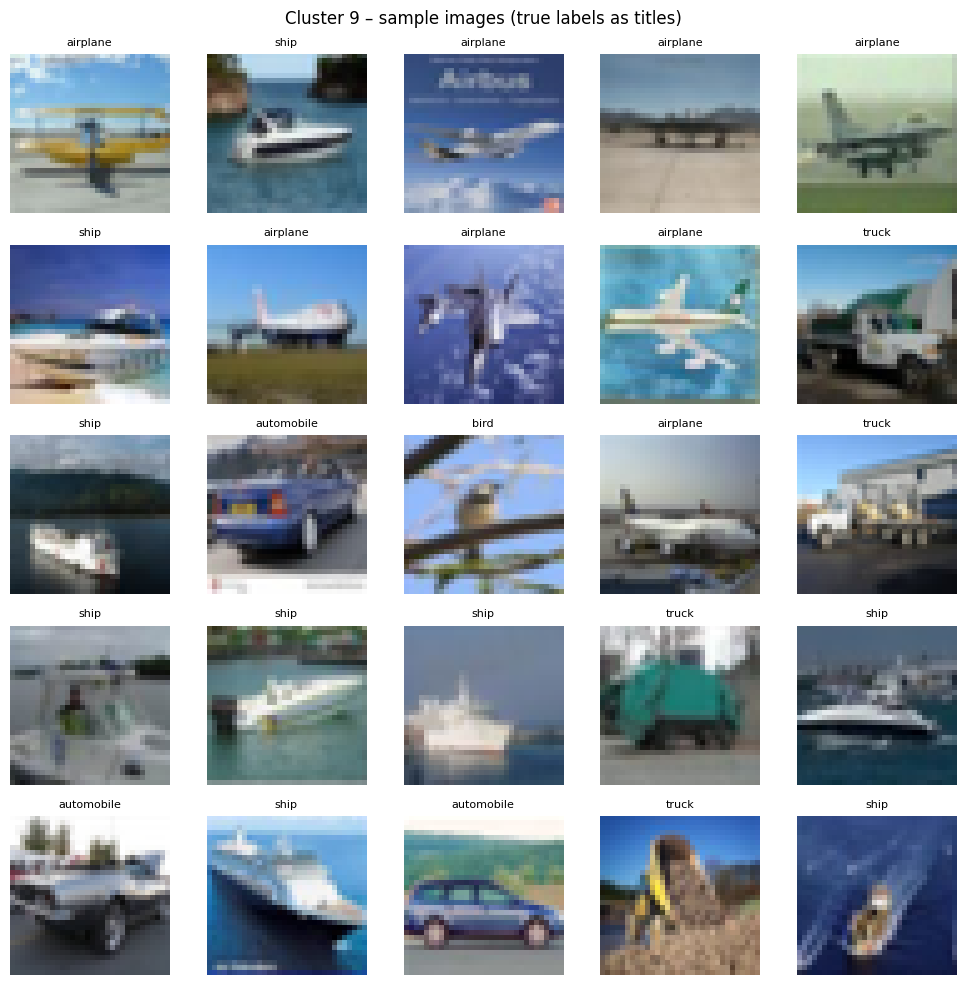

In [16]:
for c in range(k):
    show_cluster_samples(c)

In [17]:
import pandas as pd

df_clusters = pd.DataFrame({
    "cluster": clusters,
    "true_label": y_true
})

df_clusters.to_csv("cifar10_clusters.csv", index=False)

In [18]:
from google.colab import files
files.download("cifar10_clusters.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import pandas as pd
ct = pd.crosstab(clusters, y_true, rownames=['cluster'], colnames=['true_label'])
display(ct)

true_label     0     1     2     3     4     5     6     7     8     9
cluster                                                               
0            247   156  1453   345  2297   553  1706  1043   101   171
1            207  1241   159   221    35   277    91   109   352  1210
2            346   878   430  1011   447   858   270  1109   286   997
3            253  1484   334   307    32   176   107    69   704   390
4             67    48   502   949   389   945   391  1192    33    46
5             18    51   336   515    64  1442   210    79    30    10
6            420   661   215   504   398   188    44   791  1000  1560
7            108    47   516   721   849   280  2047   177    59    28
8           1819   182   919   393   314   261   117   373   490   209
9           1515   252   136    34   175    20    17    58  1945   379

In [20]:
def cluster_purity(ct):
    return ct.max(axis=1).sum() / ct.values.sum()

purity = cluster_purity(ct)
print(f"Cluster purity: {purity:.4f}")

Cluster purity: 0.3227


In [21]:
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

# centroids in PCA space
centroids = kmeans.cluster_centers_

# find nearest samples in X_pca
nearest_idx, _ = pairwise_distances_argmin_min(centroids, X_pca)

nearest_idx

array([32141, 44835, 44244, 37620, 18556, 44358,  9066,  4959, 42759,
        9895])

Cluster 0 representative (index 32141, true label bird):


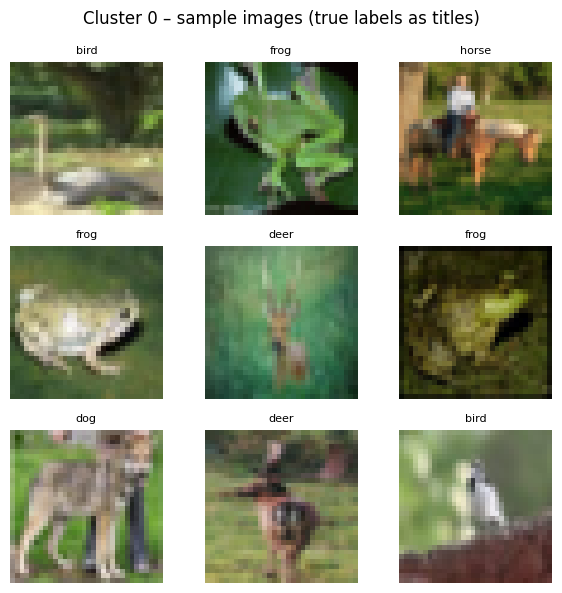

Cluster 1 representative (index 44835, true label automobile):


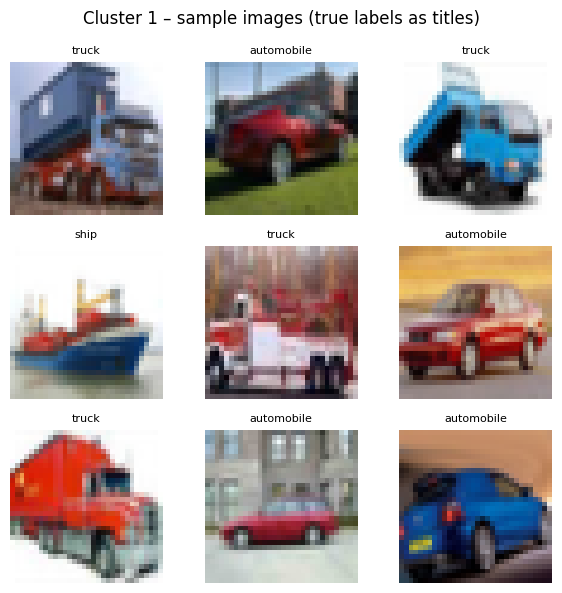

Cluster 2 representative (index 44244, true label frog):


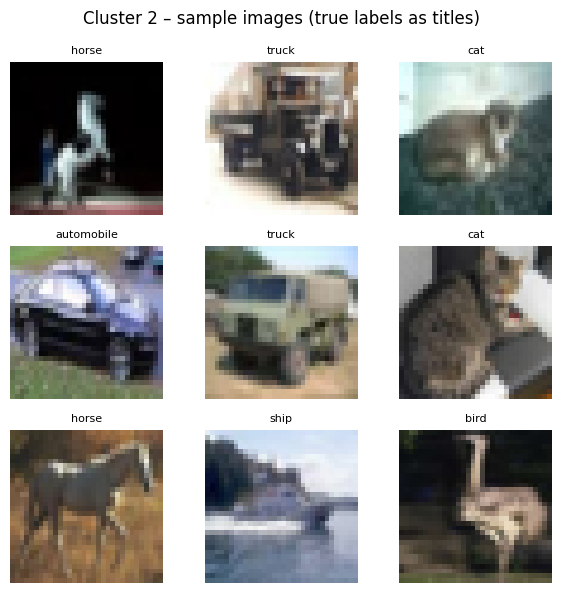

Cluster 3 representative (index 37620, true label automobile):


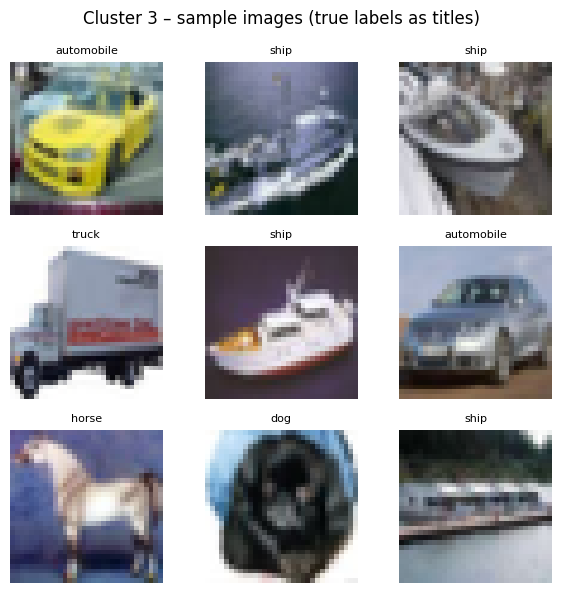

Cluster 4 representative (index 18556, true label horse):


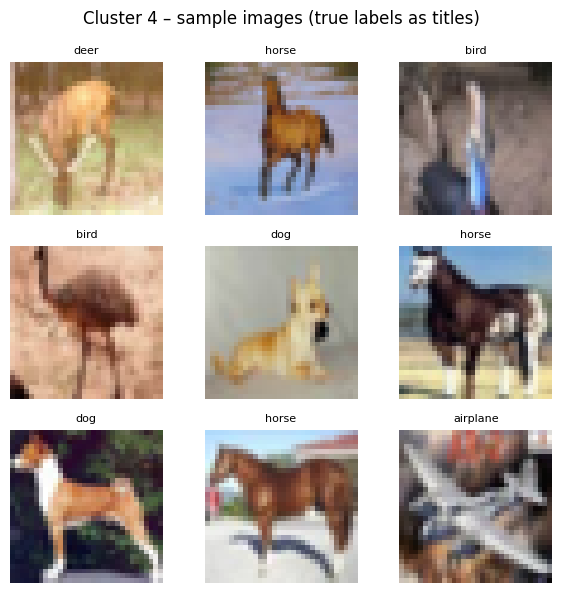

Cluster 5 representative (index 44358, true label dog):


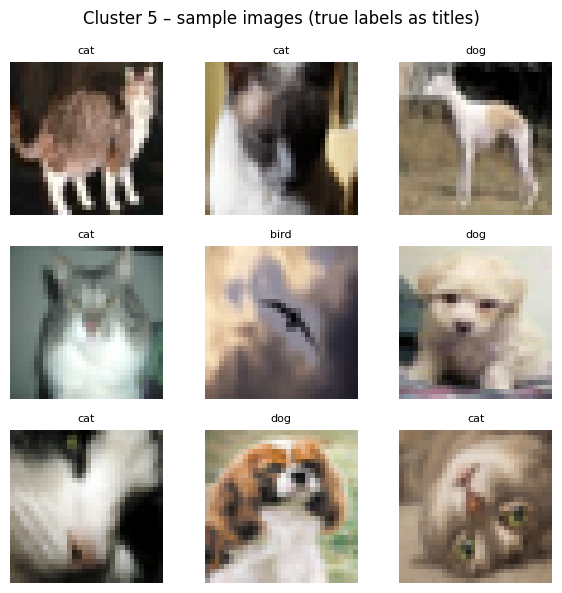

Cluster 6 representative (index 9066, true label automobile):


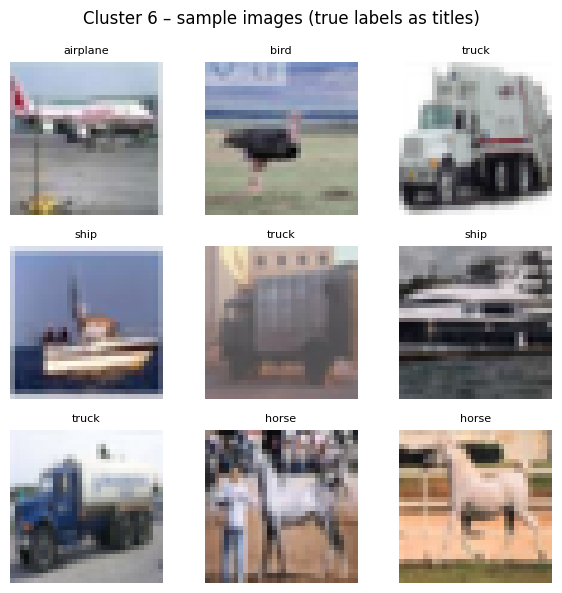

Cluster 7 representative (index 4959, true label frog):


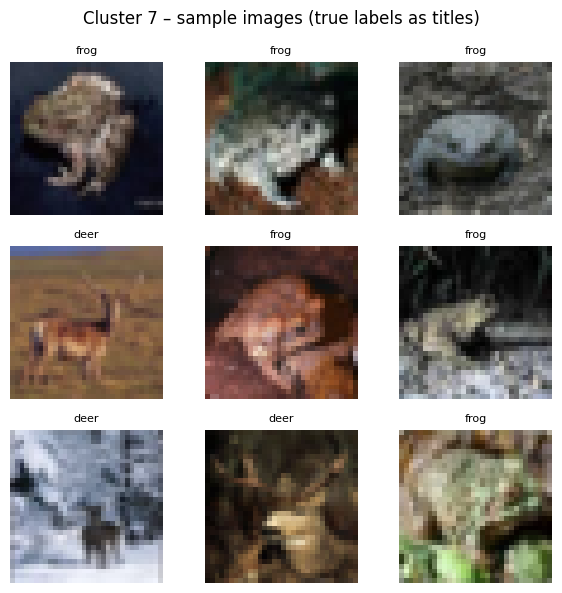

Cluster 8 representative (index 42759, true label airplane):


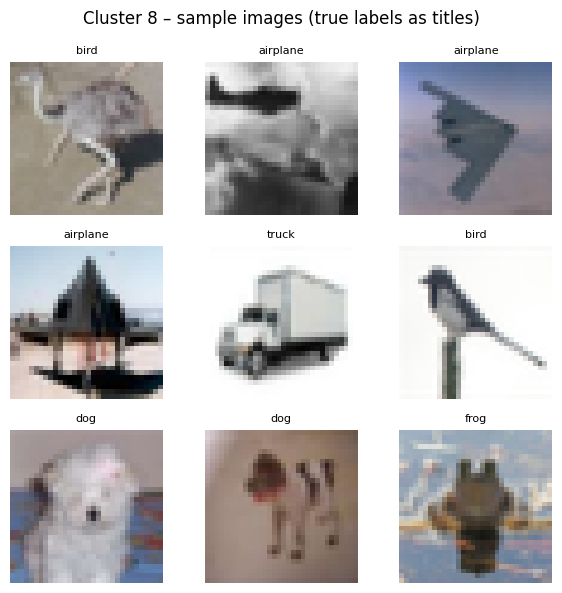

Cluster 9 representative (index 9895, true label airplane):


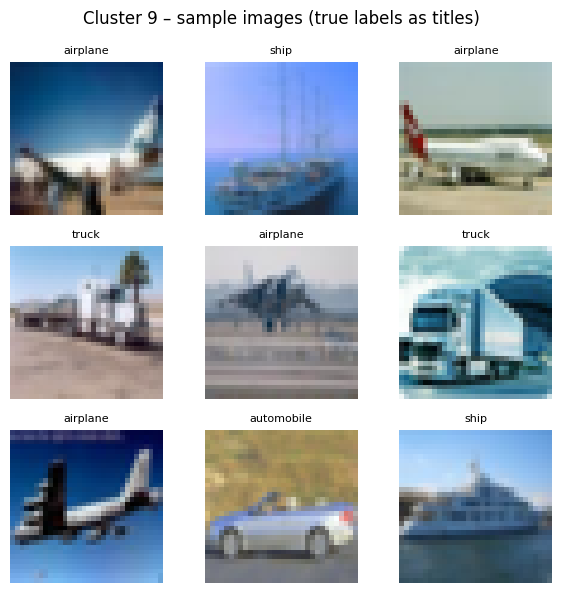

In [22]:
for i, idx in enumerate(nearest_idx):
    print(f"Cluster {i} representative (index {idx}, true label {class_names[y_true[idx]]}):")
    show_cluster_samples(clusters[idx], n=9)  # reuse function but it shows samples from that whole cluster

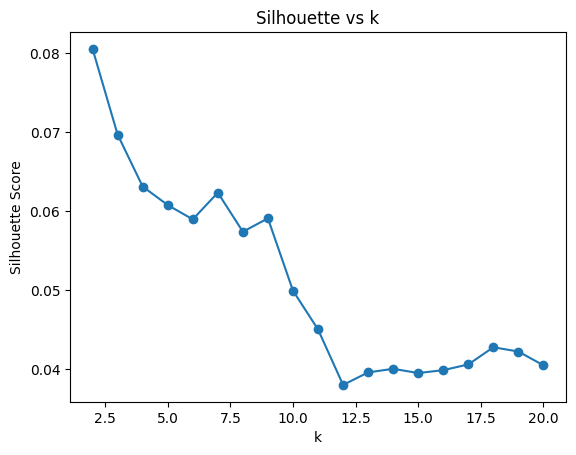

In [23]:
from sklearn.cluster import KMeans
scores = []
K_range = list(range(2, 21, 1))
for k_ in K_range:
    km = KMeans(n_clusters=k_, random_state=42, n_init=10).fit(X_pca)
    scores.append(silhouette_score(X_pca, km.labels_))

import matplotlib.pyplot as plt
plt.plot(K_range, scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette vs k')
plt.show()

Query true label: automobile
Top similar indexes: [13158 23580  6724 41131 25315 14498]


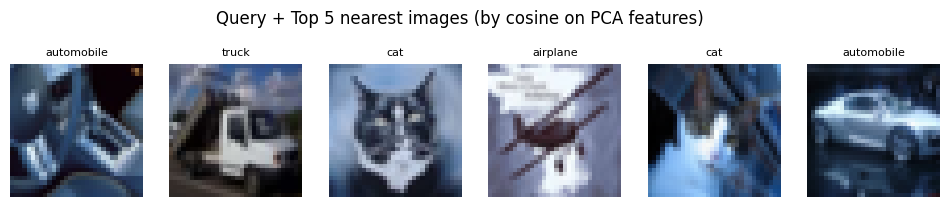

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

# compute similarity matrix between all PCA features and pick a random query
query_idx = np.random.randint(0, X_pca.shape[0])
query_vec = X_pca[query_idx:query_idx+1]
sims = cosine_similarity(query_vec, X_pca).flatten()
top_idxs = sims.argsort()[-6:][::-1]  # top 6, first is the image itself

print("Query true label:", class_names[y_true[query_idx]])
print("Top similar indexes:", top_idxs)
# display
fig, axes = plt.subplots(1, 6, figsize=(12,2.5))
for ax, ii in zip(axes, top_idxs):
    img, lbl = raw_train[ii]
    ax.imshow(np.transpose(img.numpy(), (1,2,0)))
    ax.set_title(class_names[lbl], fontsize=8)
    ax.axis('off')
plt.suptitle("Query + Top 5 nearest images (by cosine on PCA features)")
plt.show()

In [25]:
import pandas as pd
df = pd.DataFrame({
    "index": np.arange(len(clusters)),
    "cluster": clusters,
    "true_label": y_true,
    "umap1": X_umap[:,0],
    "umap2": X_umap[:,1]
})
df.to_csv("cifar10_image_clusters.csv", index=False)

# Save PCA features (optional - may be large)
import joblib
joblib.dump(X_pca, "cifar10_pca_50d.joblib")
joblib.dump(kmeans, "cifar10_kmeans.joblib")

['cifar10_kmeans.joblib']

In [26]:
from google.colab import files
files.download("cifar10_image_clusters.csv")
files.download("cifar10_pca_50d.joblib")
files.download("cifar10_kmeans.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
import gradio as gr
import numpy as np

def view_cluster(cluster_id: int):
    cluster_id = int(cluster_id)
    idxs = np.where(clusters == cluster_id)[0]
    if len(idxs) == 0:
        return []

    chosen = np.random.choice(idxs, size=min(16, len(idxs)), replace=False)
    images = []

    for i in chosen:
        img, label = raw_train[i]
        img = np.transpose(img.numpy(), (1, 2, 0))
        images.append((img, class_names[label]))

    return images

with gr.Blocks() as demo:
    gr.Markdown("### CIFAR-10 Cluster Viewer")

    c = gr.Slider(minimum=0, maximum=k-1, step=1, label="Cluster ID", value=0)

    gallery = gr.Gallery(label="Sample images in this cluster")   # <-- FIXED (removed .style)

    btn = gr.Button("Show Cluster")
    btn.click(fn=view_cluster, inputs=c, outputs=gallery)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1aeefc0b7320ee5d90.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
